# <!-- TITLE --> Unsupervised classification of sound units segmented from soundscapes
---
<!-- DESC --> Machine learning framework to perform unsupervised classification of sound units segmented from soundscapes
<!-- AUTHOR --> : Sylvain Haupert and Juan Ulloa

### Objectives :
 - Providing a script to analyze soundscapes on a GoogleDrive
 - Testing a method to rapidly screen the acoustic content in soundscapes

The goal is to provide a workflow to process soundscapes coming from different recorders set in a tropical rain forest for 24h.

### What we're going to do :

*   Installing Bambird
*   Running Bambird on a dataset
*   Checking the clusters and compare them with a library of sounds produced by expected animals.

### Dataset :

The dataset is a collection of audio recordings from the project XPRIZE (Singapore). Each audio recording lasts 30 min, and they were recorded all day long during the entire May 2022

In this script, you will use the package bambird (more specificaly some functions from bamscape that contains the functions to analyse soundscapes).


## Step 1 - Setup the environment
---

Get the information about the virtual machine that Google gave you

In [1]:
# get info about the virtual machine
!lscpu |grep 'Model name'
!lscpu |grep 'Core(s) per socket:'
!free -h --si | awk  '/Mem:/{print $2}'

Model name:                         13th Gen Intel(R) Core(TM) i7-13700H


Core(s) per socket:                 14
63G


### 1.1 Global settings

Change or adapt the settings :
- to import the required packages
- to set the directories and the paths
- to set some global constatns
- to set the parameters for bambird

In [2]:
# Load basic packages
# --------------------
import shutil
import numpy as np
from pathlib import Path
import os
import datetime
import yaml
import sys

# scikit-learn (machine learning) package
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# pandas
import pandas as pd

In [3]:
# Define constants
# ----------------

# directory where to store the data 
# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
PROJECT_PATH    = Path('/media/haupert/data/mes_projets/05_xprize/final')

# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
ARCHIVE_PATH    = Path('/media/haupert/data/mes_projets_data/xprize/')

# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
PACKAGE_PATH = Path('/media/haupert/data/mes_projets/_packages/bamscape.git')

DATA_PATH = PROJECT_PATH / Path('DATASETS')
SAVE_PATH = PROJECT_PATH / Path('RESULTS')


# subdirectories where to store the dataset and the extracted rois
DATASET_NAME    = ARCHIVE_PATH.stem + '_all'
ROIS_NAME       = Path(str(DATASET_NAME) +'_ROIS')

# subsample the dataframe containing all the audio recordings
EVERY_N_ROWS = 10 # Set to 1 to keep all files.

# audio file extension
AUDIO_EXTENSION = 'wav'

# Select the configuration file to segment, compute features and get the clusters
CONFIG_FILE     = 'config_soundscape.yaml'


Then, change the settings of bambird. The default settings seems to work well but there are not optimized. Depending on the recorder, the settings of the recorder and the place, they might be adjusted

### 1.1.2 Bambird parameters



In [4]:
#@title settings of bambird { run: "auto", vertical-output: true, form-width: "300px", display-mode: "both" }

###### bambird parameters
# parameters to segment the regions of interest (ROIS)
SAMPLE_RATE= 32000      #@param [8000, 16000, 22000, 24000, 32000, 44100, 48000, 96000, 192000] # in Hz
LOW_FREQ = 50           #@param {type:"number"} # in Hz
HIGH_FREQ= 16000        #@param {type:"number"} # in Hz
OVLP= 0                 #@param {type:"slider", min:0, max:1, step:0.05} # define the percentage of overlap (0.5 => 50%)
AUDIO_DURATION= 60      #@param {type:"number"}                          # total duration of the file that will be processed in s
CHUNK_DURATION= 10      #@param {type:"number"}                          # the file is then cut in chunk of duration CHUNK_DURATION in s
MODE_RMBCKG = 'median'  #@param ["median", "mean"]                       # select the mode to remove background
N_RUNNING_MEAN= 25      #@param {type:"slider", min:1, max:50, step:1}   # larger values will keep narrower continuous sound events
NFFT= 1024              #@param [128, 256, 512, 1024, 2048, 4096, 8192]
MASK_PARAM1 = 12        #@param {type:"slider", min:0, max:50, step:1}   # in dB (select the seeds to create the mask to segment the ROIs)
MASK_PARAM2 = 6         #@param {type:"slider", min:0, max:50, step:1}   # in dB (select the lowest value that will be part of the mask to segment the ROIs)
MAX_RATIO_YX = 11       #@param {type:"slider", min:1, max:20, step:1}   # remove vertical narrow ROIs (mostly rain or noire)
MARGIN_T_LEFT= 0.1      #@param {type:"number"} #overlapping time margin in s on the left side of the ROI to merge
MARGIN_T_RIGHT= 0.1     #@param {type:"number"} #overlapping time margin in s on the right side of the ROI to merge
MARGIN_F_BOTTOM= 100     #@param {type:"number"} #overlapping frequency margin in Hz on the bottom of the ROI to merge
MARGIN_F_TOP= 100        #@param {type:"number"} #overlapping frequency margin in Hz on the top of the ROI to merge
# Save ROIs parameters
MARGIN_T= 0.1           #@param {type:"number"}  # time margin in s around the ROI
MARGIN_F= 100           #@param {type:"number"}  # frequency margin in Hz around the ROI
FILTER_ORDER= 5         #@param {type:"number"}  # butterworth filter order to select the bandwidth corresponding to the ROI

# parameters to cluster  the ROIs
METHOD = 'HDBSCAN'      #@param ["DBSCAN", "HDBSCAN"]                   # clustering methods
MIN_PTS = 5             #@param {type:"number"}                         # min number of points to form a cluster
EPS = 'auto'               #@param {type:"raw"}                            # 'auto' or a value between 0 to 2 , usually between 0.05 and 0.15
# select the features that will be used to perform the clustering
shp = True              #@param {type:"boolean"}
centroid_f = True       #@param {type:"boolean"}
peak_f = True           #@param {type:"boolean"}
duration_t = False       #@param {type:"boolean"}
bandwidth_f = True     #@param {type:"boolean"}
bandwidth_min_f = False #@param {type:"boolean"}
bandwidth_max_f = False #@param {type:"boolean"}
min_f = False           #@param {type:"boolean"}
max_f = False           #@param {type:"boolean"}

FEATURES = []
if shp : FEATURES.append('shp')
if centroid_f : FEATURES.append('centroid_f')
if peak_f : FEATURES.append('peak_f')
if duration_t : FEATURES.append('duration_t')
if bandwidth_f : FEATURES.append('bandwidth_f')
if bandwidth_min_f : FEATURES.append('bandwidth_min_f')
if bandwidth_max_f : FEATURES.append('bandwidth_max_f')
if min_f : FEATURES.append('min_f')
if max_f : FEATURES.append('max_f')



### other global parameters

In [5]:
# select the ROIs with SNR higher than SNR_HLIM
SNR_HLIM = 0           #@param {type:"slider", min:0, max:90, step:1}

# Define the margins in time and frequency for the ROIs that will be sent
# to the experts
ROIS_NAME_EXPERT = Path(str(ROIS_NAME) + '_EXPERT')
MARGIN_T_EXPERT = 0.75 # 750 ms => 1.5s min
MARGIN_F_EXPERT = 1000 # 1kHz   => 2kHz min

### 1.1.2 Define some local functions

In [6]:
# %%
def date_from_filename (filename) :
    # filename with format 'XXXX_yyyymmdd_hhmmss.wav'
    # extract year, month, day, hour, minute and second from the filename
    # notice the underscore _ which splits the filename into several parts
    year = int(filename.split('_')[1][0:4])
    month = int(filename.split('_')[1][4:6])
    day = int(filename.split('_')[1][6:8])
    hour = int(filename.split('_')[2][0:2])
    minute = int(filename.split('_')[2][2:4])
    #second = int(filename.split('_')[2][4:6])
    second = 00

    # create a datetime object from the extracted parameters
    date = datetime.datetime(year, month, day, hour, minute, second)

    return date

# %%
def find_representative_samples (df_cluster):
            
    # copy
    df = df_cluster.copy()

    # set cluster_number as the index
    # df.set_index("cluster_number", inplace = True)

    # compute the average shapes for each filename
    df['features'] = df['features'].apply(lambda x: np.array(x))
    
    df_avg = pd.DataFrame({'features' : df.groupby('cluster_number')['features'].apply(np.mean)})
    
    # dataframe with the nearest samples to the center of each cluster
    df['dist_likeness'] = np.nan
    df['normdist'] = np.nan
    df['dist'] = np.nan
    df['cosine_likeness'] = np.nan
    df['cosine'] = np.nan
    df['model'] = 0
    
    
    for index, y in df_avg.iterrows():  

        # if noise, continue
        if index == -1 :
            continue
        
        # variables
        y = y.features 
        X = np.array(df[df.cluster_number == index].features.tolist())

        # distance
        neighbors = NearestNeighbors(n_neighbors=len(X))
        neighbors_fit = neighbors.fit(X)
        distances, index_sample = neighbors_fit.kneighbors([y])       
        d = distances[0]
        # angle
        a = cosine_similarity(X, y.reshape(1,-1)).flatten()
        
        # Give an indicator of the likeness of the sample regarding its cluster
        #-------------------------------------------------------------------------
        # 1 is the closest sample to the model (the most likeness of the cluster)
        # 0.5 is as half the distance between /REC4_20210527_2335_10s_04.wav /REC4_20210527_2340_0s_08.wav /REC4_20210527_2340_0s_10.wav /REC4_20210527_2340_0s_12.wav /REC4_20210527_2340_0s_14.wav /REC4_20210527_2340_30s_03.wav /REC4_20210527_2340_30s_05.wav /REC4_20210527_2340_30s_07.wav /REC4_20210527_2340_30s_08.wav /REC4_20210527_2340_30s_12.wav /REC4_20210527_2340_30s_13.wav /REC4_20210527_2340_30s_14.wav /REC4_20210527_2340_30s_15.wav /REC4_20210527_2340_30s_17.wav /REC4_20210527_2340_30s_18.wav /REC4_20210527_2340_40s_06.wav /REC4_20210527_2340_40s_11.wav /REC4_20210527_2340_50s_06.wav /REC4_20210527_2355_10s_07.wav /REC4_20210528_0950_30s_04.wavthe furthest and the closest
        # 0 is the furthest sample (should be very different to the avg sample)
        df.update(pd.DataFrame({'dist_likeness': 1-(d-min(d))/(max(d)-min(d))},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # normalized distance
        # 1 is the closest to the model 
        # 2 is twice the distance to the model
        # 10 is ten times the minimum distance to the model
        df.update(pd.DataFrame({'normdist': d/d[0]},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # absolute distance
        d = distances[0]
        df.update(pd.DataFrame({'dist': d},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # similarity (cosine)
        # 1 both vectors are colinear (the angle is 0°)
        # 0 both vectors are orthogonal (the angle is 90°)
        df.update(pd.DataFrame({'cosine': a},
                                index =  df[df.cluster_number == index].index ))
        # 1 is the closest sample to the model (the most likeness of the cluster)
        # 0.5 is as half the angle between the furthest and the closest
        # 0 is the furthest sample (should be very different to the avg sample)
        df.update(pd.DataFrame({'cosine_likeness': (a-min(a))/(max(a)-min(a))},
                                index =  df[df.cluster_number == index].index ))

        # df_cluster_per_file['features'] = df_cluster_per_file['features'].apply(lambda x: np.array(x))
        # # Compute the silhouette scores for each sample
        # X = np.array(df_cluster_per_file.features.tolist())
        # silhouette = silhouette_samples(X, df_cluster_per_file['cluster_number'])
        # df_cluster_per_file['silhouette'] = silhouette


        # add a column "model"
        # 1 => the closest to the average features = model, 0 either.        
        idx = df[df.cluster_number == index].iloc[index_sample[0][0]].name
        df.at[idx,'model'] = 1

    return df

# %%
def select_cluster_percentile (
                            df_cluster,
                            column      = "cluster_number",
                            percentile  = 75,
                            remove_noise= True
                            ) :
    # Count the number of ROIs per cluster and select the first "percentile" of
    # cluster, from the biggest (percentile = 1) to the smallest (percentile = 99)
    # Does not take into account the cluster "noise" (=-1)

    # copy the dataframe
    df = df_cluster.copy()

    # clean df_cluster by removing the noise : -1
    if remove_noise :
        df = df[df[column] >-1]

    # count the number of each value
    counts = df[column].value_counts()

    # sort counts value from the highest count to the lowest
    counts = counts.sort_values(ascending=False)

    # select the vector of id
    cumulative = counts.cumsum() / counts.sum()
    mask = cumulative > (percentile / 100)
    idx = cumulative[mask].index[0]
    selected = counts.loc[:idx]

    # filter the dataframe to keep only the biggest clusters
    df = df[df[column].isin(selected.index)]

    return df

## Step 2 - Data processing
---

Load the configuration file. In case of soundscapes, the file ***config_soundscape.yaml*** works well for most soundscapes. Of course you can also edit the file and adapt the parameters to your need.

## 2.1 Import and configuration

In [7]:
# import the custom packages
#----------------------------
import maad
import bambird

In [8]:
# Load the configuration file
# -----------------------------
params = bambird.load_config(PACKAGE_PATH / "src/bambird" / CONFIG_FILE)

# change some parameters
params['PARAMS_EXTRACT']['SAMPLE_RATE'] = SAMPLE_RATE
params['PARAMS_EXTRACT']['HIGH_FREQ'] = HIGH_FREQ
params['PARAMS_EXTRACT']['LOW_FREQ'] = LOW_FREQ
params['PARAMS_EXTRACT']['OVLP'] = OVLP
params['PARAMS_EXTRACT']['AUDIO_DURATION'] = AUDIO_DURATION
params['PARAMS_EXTRACT']['CHUNK_DURATION'] = CHUNK_DURATION
params['PARAMS_EXTRACT']['MARGIN_T_LEFT'] = MARGIN_T_LEFT
params['PARAMS_EXTRACT']['MARGIN_T_RIGHT'] = MARGIN_T_RIGHT
params['PARAMS_EXTRACT']['MARGIN_F_BOTTOM'] = MARGIN_F_BOTTOM
params['PARAMS_EXTRACT']['MARGIN_F_TOP'] = MARGIN_F_TOP
params['PARAMS_EXTRACT']['MARGIN_T'] = MARGIN_T
params['PARAMS_EXTRACT']['MARGIN_F'] = MARGIN_F

params['PARAMS_EXTRACT']['MODE_RMBCKG'] = MODE_RMBCKG
params['PARAMS_EXTRACT']['N_RUNNING_MEAN'] = N_RUNNING_MEAN
params['PARAMS_EXTRACT']['NFFT'] = NFFT

params['PARAMS_EXTRACT']['MASK_PARAM1'] = MASK_PARAM1
params['PARAMS_EXTRACT']['MASK_PARAM2'] = MASK_PARAM2
params['PARAMS_EXTRACT']['MAX_RATIO_YX'] = MAX_RATIO_YX

params['PARAMS_FEATURES']['SAMPLE_RATE'] = SAMPLE_RATE
params['PARAMS_FEATURES']['HIGH_FREQ'] = HIGH_FREQ
params['PARAMS_FEATURES']['LOW_FREQ'] = LOW_FREQ

params['PARAMS_CLUSTER']['METHOD'] = METHOD
params['PARAMS_CLUSTER']['MIN_PTS'] = MIN_PTS
params['PARAMS_CLUSTER']['FEATURES'] = FEATURES
params['PARAMS_CLUSTER']['EPS'] = EPS

use the function <bambird.extract_rois_in_soundscape> to segment ROIS


## 2.2 Grab and prepare audio

In [9]:
# Grab audio
# -------------------
df = bambird.grab_audio_to_df(ARCHIVE_PATH, AUDIO_EXTENSION)

# grab all audio recording files in the dataset
#filelist = glob(ARCHIVE_PATH+'/**/*'+'.'+AUDIO_EXTENSION, recursive = True)

# create a column date
df['date'] = df.filename.apply(date_from_filename)

# print the number of audio recordings
print("The number of audio recordings is %d" %len(df))

The number of audio recordings is 216


**Subsamples the dataframe** in order to make quick tests

In [10]:
# Keep rows every N rows
df = df.iloc[::EVERY_N_ROWS, :]

# print the number of audio recordings
print("The number of audio recordings that will be processed is %d" %len(df))

The number of audio recordings that will be processed is 22


## 2.3 Extract ROIS



*   First extract ROIS of a single file in order to see if the parameters are fine.
*   Display the SNR for each ROIS found in the audio file




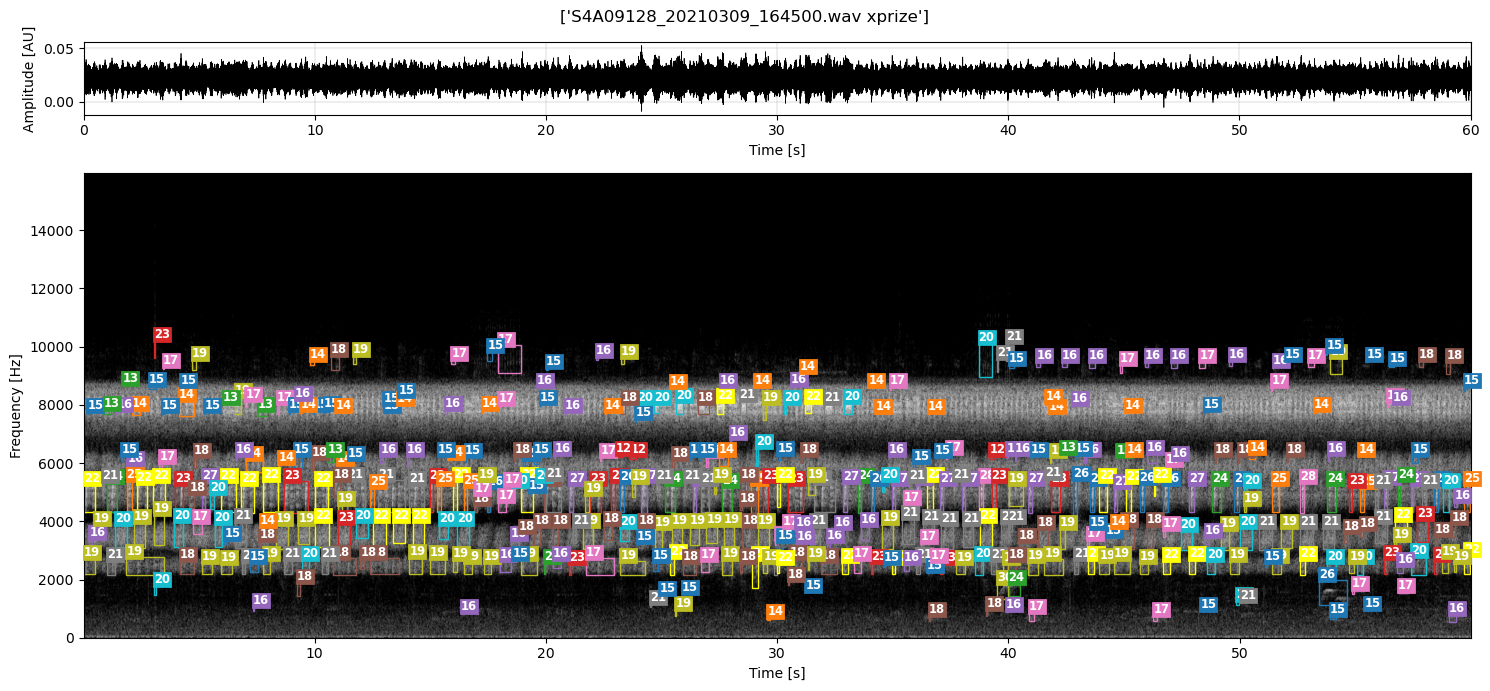

In [22]:
# Extract ROIS of a single file
# -------------------------------

# ROIS extraction of a single file
df_rois_single = bambird.single_file_extract_rois (
                    audio_path  = df.sample().fullfilename.squeeze(),
                    #audio_path  = ARCHIVE_PATH/'REC1_20210528_0745.wav',  # if a specific file needs to be tested
                    fun         = params['PARAMS_EXTRACT']['FUNC'],
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME,
                    display     = False,
                    verbose     = False)

# and display the ROIs on the file
# convert the column snr into integer in order to use the value as a label for each ROI
# This is temporary, only on df_rois_single that will not be used after
if len(df_rois_single) > 0 : # test if there is at least a single ROI
  df_rois_single["snr"] = df_rois_single["snr"].apply(int)
  bambird.overlay_rois(
                      cluster         = df_rois_single,
                      params          = params['PARAMS_EXTRACT'],
                      column_labels   = 'snr', 
                      unique_labels   = np.sort(df_rois_single.snr.unique()),
                      filename        = None,
                      random_seed     = None,
                      verbose         = False
                      )
else :
  print("No ROI was found")

Extract all the ROIS. It takes about an hour for 300 1 min audio files

In [12]:
# Extract ROIS
# -------------------------------

# ROIS extraction of the full dataset
df_rois, csv_rois = bambird.multicpu_extract_rois(
                    dataset     = df,
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME,
                    overwrite   = True,
                    verbose     = True
                    )

print("{} rois were found".format(len(df_rois)))

======================= EXTRACT ROIS =========================

The directory /media/haupert/data/mes_projets/05_xprize/final/DATASETS/xprize_all_ROIS already exists and will be overwritten
No audio file needs to be segmented
>>> EXTRACTION PROCESS ABORTED <<<
6579 rois were found


Extract all the ROIs for Experts (with large margins in time and frequency around the ROI)

In [ ]:
# Extract ROIS for experts
# -------------------------------

params['PARAMS_EXTRACT']['MARGIN_T'] = MARGIN_T_EXPERT # 750 ms => 1.5s min
params['PARAMS_EXTRACT']['MARGIN_F'] = MARGIN_F_EXPERT # 1kHz   => 2kHz min

# ROIS extraction of the full dataset
df_rois_expert, csv_rois_expert = bambird.multicpu_extract_rois(
                    dataset     = df,
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME_EXPERT,
                    overwrite   = True,
                    verbose     = True
                    )

print("{} rois were found".format(len(df_rois)))

## 2.4 Compute features
It takes about an hour for about 20 000 ROIs

In [13]:
# Compute features for each ROIS
# -------------------------------

# compute the features on the full dataset
df_features, csv_features = bambird.multicpu_compute_features(
                dataset     = df_rois,
                params      = params['PARAMS_FEATURES'],
                save_path   = DATA_PATH / ROIS_NAME,
                overwrite   = True,
                verbose     = True)




====================== COMPUTE FEATURES ======================

No feature needs to be computed
>>> FEATURES COMPUTING PROCESS ABORTED <<<


# Step 3 - Clustering and display

In [14]:
# Select ROIS with high SNR
#--------------------------------
df_features_selected = df_features[df_features.snr >= SNR_HLIM]
print("Keep {} ROIs with SNR >= {}dB over {}".format(len(df_features_selected), SNR_HLIM, len(df_features)))

Keep 6579 ROIs with SNR >= 0dB over 6579


In [15]:
#  Cluster ROIS
# -------------------------------

# find the clusters by categories
df_cluster, csv_cluster = bambird.find_cluster(
                dataset = df_features_selected,
                params  = params['PARAMS_CLUSTER'],
                display = False,
                verbose = True
                )



====================== CLUSTER FEATURES ======================

HDBSCAN eps 0.08762044149077786 min_points 5 Number of soundtypes found for xprize : 175




============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/S4A09128_20210309_164500.wav
labels : [126  -1  -1  70  70  70  71  71  71  71  70  70  70  70  71  57  42  42
  42  57  42  56  42 112  57  42  56 107 107 107  45  46  45  46  45  45
  46  46  46  -1  45  -1  -1 139 139 129  16  -1  -1  36   9  -1  37  81
  -1   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   8
   8  30  -1  -1 128 160 131  87  70  70  70  70  -1  70  71  71  71  70
  71  71  -1  57  42  42  42  42  42  42  42  56  56  -1  46 105  45  45
  46  45 105  46 105  46  -1  46  45  46  41  41  41 139 139 129 129 171
 147  37  37  36  63  63  80  51  -1  51  81  59   5   5   5   5   5   5
   5   5   5   5  49  -1  -1  -1 128  -1  78  -1  -1  -1 120  -1  71  71
  71  70  71  70  71  70  71  71  71  71  71  42  42  57  42  42  42  -1
  42  57  42  56  56  56  56  56  56  -1  46  45  46  45  45  46  -1  45
  46  46  46  46 

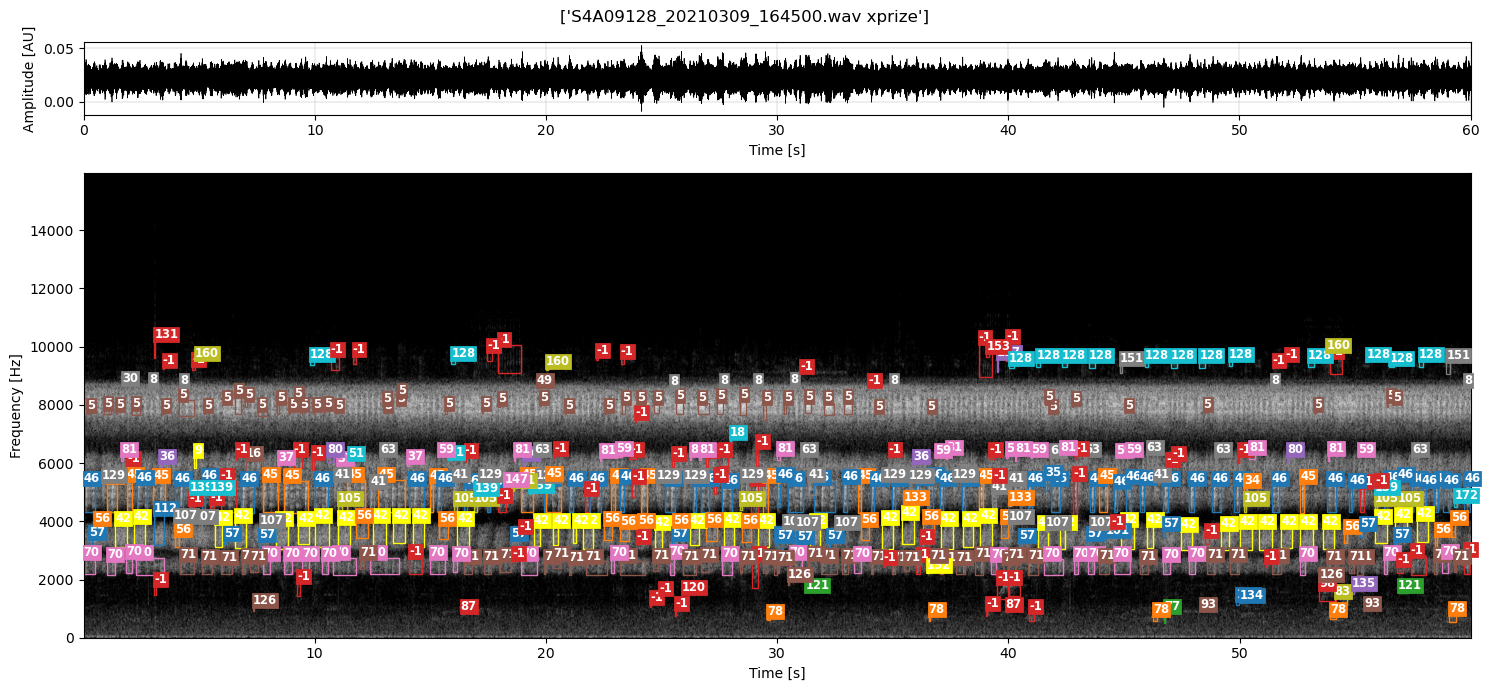

'S4A09128_20210309_164500.wav'

In [23]:
# Display the ROIS
# -------------------------------

bambird.overlay_rois(
                    cluster         = df_cluster,
                    params          = params['PARAMS_EXTRACT'],
                    column_labels   = 'cluster_number', #auto_label cluster_number
                    unique_labels   = np.sort(df_cluster.cluster_number.unique()),
                    filename        = None,
                    # filename        = 'S4A09128_20210309_164500.wav',
                    random_seed     = None,
                    verbose         = True
                    )

In [17]:
# Select the most important clusters
# ------------------------------------
#df_cluster_selected = select_cluster_percentile(df_cluster, percentile = 90)

#print("We select {} clusters over {} which regroup 90% of the rois" .format(len(df_cluster_selected['cluster_number'].value_counts().index), len(df_cluster['cluster_number'].value_counts().index)))

Compute different metrics (cosine_likeness dist_likeness normdist) to estimate the likeness or the distance to the "centroid" of a cluster (= features of all ROIs that belongs to a cluster are averaged)

In [18]:
# find representative samples and save dataframe
#-------------------------------------
df_cluster_repsamples = find_representative_samples(df_cluster)

In [19]:
# Group the dataframe by category and get the top 20 rows per category based on lowest normdist. Remove noise cluster (-1)
cols = ['cluster_number', 'filename_ts',  'fullfilename_ts', 'fullfilename','filename', 'min_t', 'max_t', 'min_f', 'max_f', 'normdist']
df_cluster_selected = df_cluster_repsamples[cols].groupby('cluster_number').apply(lambda x: x.nsmallest(20, 'normdist') if len(x) >= 20 else x)
df_cluster_selected = df_cluster_selected.loc[~ (df_cluster_selected.cluster_number==-1),:]
df_cluster_selected['group (insect, bird, bat, frog, noise, unknown)'] = ''
df_cluster_selected['scientific_name'] = ''
df_cluster_selected['english_name'] = ''

# save
filename = str(DATASET_NAME) + '_CLUSTERS.csv'
# test if the directory exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
df_cluster_selected.to_csv(SAVE_PATH / filename, index=False)

In [ ]:
# Save the most representative ROIS of each cluster in folders
for index, row in df_cluster_selected.iterrows():
    # get the cluster number
    cluster_number = row.cluster_number
    # create the path
    folder = Path(str(DATASET_NAME) +  ('_CLUSTERS')) 
    # create the folders and subfolders
    try:
        os.makedirs(SAVE_PATH / folder / str(cluster_number))
    except FileExistsError:
        # directory already exists
        print("directory {} already exists".format(SAVE_PATH / folder / str(cluster_number)))
        pass
    # copy paste the file in the right directory 
    try : 
        src = DATA_PATH / ROIS_NAME_EXPERT  / Path(row.fullfilename).parts[-2] /row.filename_ts
        dst = SAVE_PATH / folder / str(cluster_number) / row.filename_ts
        shutil.copy2(src,dst)
    except  :
        # directory already exists
        print("file {} does not exist".format(DATA_PATH / ROIS_NAME_EXPERT))
        df_cluster_selected.drop(index=index, inplace=True)
        pass

Select the metric and then display the most representative ROI of the cluster and then the random ROIs that are below or upper of a threshold

In [108]:
from maad.util.visualization import plot_spectrogram
import matplotlib.pyplot as plt
from math import ceil
from scipy import signal

# Create vignettes with the most representative ROIs for each cluster
#----------------------------------------------------------------------

# get the cluster number list from the biggest cluster to the smallest
cluster_number_list = df_cluster_selected['cluster_number'].value_counts().index

# prepare the grid
columns = 4
rows = ceil(len(cluster_number_list) / columns)
fig, axes = plt.subplots(rows, columns, figsize = (20,20/4*rows))

# Max number of samples by cluster
NUM_SAMPLES = 5

# select the metric to construct the vignette
metric = 'normdist' #cosine_likeness dist_likeness normdist
METRIC_THRESHOLD = 2

ii = 0

# 1. zero padding
#-----------------------------------------------------------------------
# get the fs
_, fs = maad.sound.load(df_cluster_selected.fullfilename_ts.values[0])

# create the vector of zero padding
duration = 0.5 # in seconds
sig0 = [0] * int(fs*duration)

# 2. load 5 audio for each cluster and concatenate them into a single audio
#-----------------------------------------------------------------------

for num in cluster_number_list:

    df = df_cluster_selected[df_cluster_selected['cluster_number'] == num]

    # Sort the dataframe by the value of the metric
    df = df.sort_values(by=metric)

    # keep only the rows with the metric lower or equal than the threshold
    df = df[df[metric]<=METRIC_THRESHOLD]

    # Sample the rows. Get a maximum of NUM_SAMPLES rows. 
    # Could be less if the dataframe as less rows
    df = df.sample(min(NUM_SAMPLES,len(df)))

    # initialize an empty list
    sig = []

    for _ , row in df.iterrows() :

        fullfilename_ts = row.fullfilename_ts
        sig1, fs = maad.sound.load(fullfilename_ts)
        window = signal.windows.tukey(len(sig1), alpha=0.05)
        sig1 = (sig1 * window).tolist()

        # merge all sig with zero padding in between
        sig0 +=sig1
        sig +=sig0
    
    # list to array
    sig = np.asarray(sig)
    
    # Compute the spectrogram of the concatenate audio
    Sxx, tn, fn, ext = maad.sound.spectrogram(sig, fs, nperseg=1024)

    # Plot the spectrogram in the right subplot
    rr = ii // columns
    cc = ii - rr * columns
    maad.util.plot_spectrogram(Sxx, extent=ext, 
                                db_range=60, gain=20, 
                                now = False,
                                title = 'cluster ' + str(num),
                                colorbar=False, ax=axes[rr, cc])

    ii = ii +1

# 3. Save figure
#-----------------------------------------------------------------------
filename = str(DATASET_NAME) + '.pdf'
plt.savefig(SAVE_PATH /filename)
filename = str(DATASET_NAME) + '.png'
plt.savefig(SAVE_PATH /filename)

# Display
plt.show()